# **Proyecto Generación de música automática**

![picture](https://www.smartpiano.com.au/wp-content/uploads/2017/11/Fotolia_83643105_Subscription_Monthly_M.jpg)

El presente proyecto se trata de la creación automática de pequeños fragmentos musicales usando diferentes párameteros como intervalos, acordes, ritmos, tempo, entre otros, a partir de obras para piano de compositores  principalmente del clasicismo y del romanticismo en formato MIDI que se encuentran disponibles en Kaggle en el siguiente enlace: https://www.kaggle.com/soumikrakshit/classical-music-midi

## **0. Objetivos**



*   Implementar un modelo que permita la generación de fragmentos musicales para piano a partir de ciertos parámetros introducidos por el usuario (específicamente el número de notas de la melodía)
*   Utilizar una red neuronal LSTM como modelo de Deep Learning





## **1. Dataset**

Descargamos el dataset que se encuentra en Google Drive

In [ ]:
!gdown 1L-4v6oKVdPqMsgNF84ns7xlMSY2-2Eyn

Downloading...
From: https://drive.google.com/uc?id=1L-4v6oKVdPqMsgNF84ns7xlMSY2-2Eyn
To: /content/Music_generation.zip
100% 2.45M/2.45M [00:00<00:00, 12.9MB/s]


Los audios en formato MIDI se encuentran comprimidos en zip y los incluimos en la carpeta 'music':

In [ ]:
!mkdir music

In [ ]:
!unzip "/content/Music_generation.zip" -d 'music'

Tenemos en total 295 archivos MIDI:

In [ ]:
import os
count = 0
for root_dir, cur_dir, files in os.walk('music'):
    count += len(files)
print('file count:', count)

file count: 295


Veámos la estructura de los datos en la carpeta 'music'

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (125 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
!tree music

# **2. Exploración y Preprocesamiento de los datos**

Para este proyecto vamos a ser uso extensivo de la librería music21, la cual permite analizar los archivos MIDI y extraer las notas (entendidas como frecuencias o alturas y sus duraciones) y acordes (notas que suenan simultáneamente) del archivo.

In [ ]:
from IPython.display import display
import music21
import sklearn
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

Lectura y análisis de los archivos MIDI

In [ ]:
def extract_notes(file):
  notes=[]
  pick=None
  #convertimos el archivo midi
  midi=converter.parse(file)
  #separamos los instrumentos del archivo
  instrmt=instrument.partitionByInstrument(midi)

  for part in instrmt.parts:
    #separamos los datos solamente para piano
    if 'Piano' in str(part):
      pick=part.recurse()

      #se itera sobre los elementos
      #Se verifica si el elemento es nota o acorde, en caso de este último se separa en notas

      for element in pick:
        if type(element)==note.Note:
          notes.append(str(element.pitch))
        elif type(element)==chord.Chord:
          notes.append('.'.join(str(n) for n in element.normalOrder))

  #retornamos una lista de las notas
  return notes

Por simplicidad vamos a utilizar solamente los archivos MIDI del compositor noruego Edvard Grieg:

In [ ]:
def corpus_gen(file_path):
  all_files=glob.glob(file_path[0]+'/*.mid',recursive=True)
  #conformamos el corpus con los archivos MIDI preprocesados
  corpus = np.array([extract_notes(i) for i in all_files], dtype=object)
  return corpus

In [ ]:
path = "music/grieg"
corpus = corpus_gen(path)

Revisemos cuántas notas únicas se tienen y cuál es su distribución:

Unique Notes: 248
30 : 116
50 : 89
70 : 64
90 : 51
110 : 44
130 : 33
150 : 29
170 : 23
190 : 16


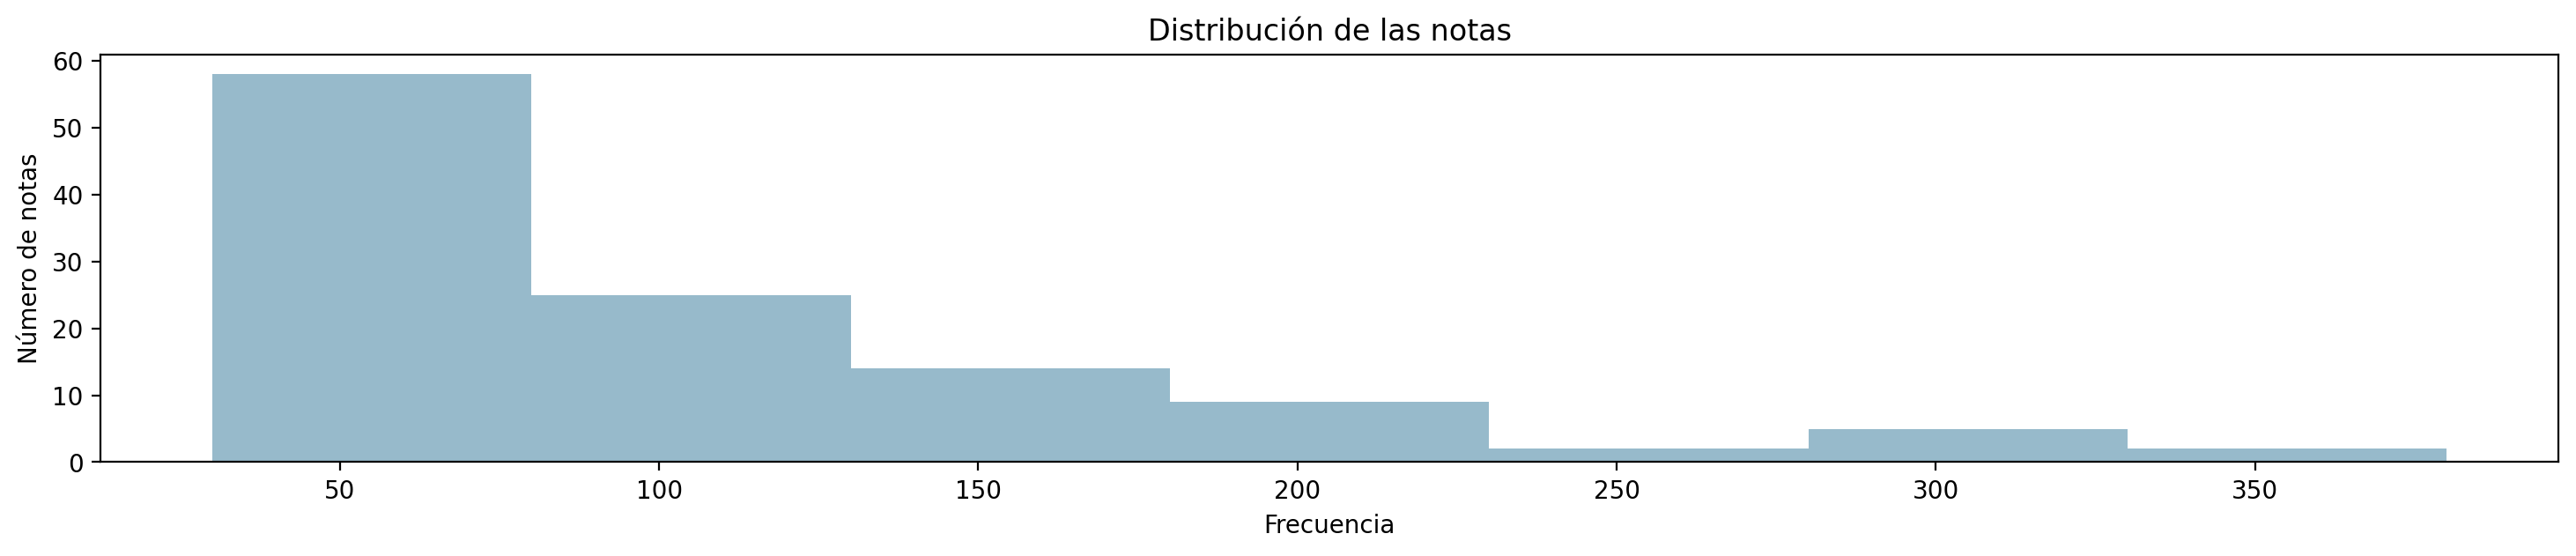

In [ ]:
#notas únicas
notess = sum(corpus,[])
unique_notes = list(set(notess))
print("Unique Notes:",len(unique_notes))
#notas con su frecuencia
freq=dict(map(lambda x: (x,notess.count(x)),unique_notes))
recurrence = list(freq.values())
for i in range(30,200,20):
  print(i,":",len(list(filter(lambda x:x[1]>=i,freq.items()))))
#gráfica
plt.figure(figsize=(18,3))
bins = np.arange(30,max(recurrence), 50)
plt.hist(recurrence, bins=bins, color="#97BACB")
plt.title("Distribución de las notas")
plt.xlabel("Frecuencia")
plt.ylabel("Número de notas")
plt.show()


Seleccionamos un umbral para la frecuencia de las notas para remover sonidos de baja frecuencia y facilitar la generación de la música

In [ ]:
umbral = 50
freq_notes=dict(filter(lambda x:x[1]>=umbral,freq.items()))
#creamos nuevas notas usando la frecuencia
new_notes=[[i for i in j if i in freq_notes] for j in corpus]

Creamos diccionarios con los índices de las notas como keys y notas como values y viceversa:

In [ ]:
#diccionario con el índice de nota como key y la nota como value
ind2note=dict(enumerate(freq_notes))
#diccionario con la nota como key y el índice de nota como value
note2ind=dict(map(reversed,ind2note.items()))
print(ind2note.items())
print(len(ind2note))

dict_items([(0, 'D5'), (1, 'G4'), (2, '6.9'), (3, '5.9'), (4, 'F#4'), (5, 'D4'), (6, 'G#3'), (7, 'E-2'), (8, '8.11'), (9, '1.4'), (10, '2.7'), (11, '11.4'), (12, 'C#5'), (13, '4.9'), (14, 'B4'), (15, '9.2'), (16, 'F5'), (17, 'G#5'), (18, 'C4'), (19, 'C#6'), (20, 'G5'), (21, 'D6'), (22, '10.3'), (23, 'F#2'), (24, 'F6'), (25, '10.1'), (26, '0'), (27, 'A3'), (28, 'C#4'), (29, 'G2'), (30, 'E3'), (31, '10.2'), (32, '7.11'), (33, '11.3'), (34, 'E6'), (35, '9'), (36, 'D2'), (37, 'C6'), (38, 'A4'), (39, 'B5'), (40, 'C#3'), (41, '7.10'), (42, '6.10'), (43, 'A2'), (44, 'E4'), (45, '2.5'), (46, '1.6'), (47, '6.10.1'), (48, 'G#4'), (49, '9.10'), (50, '4.7'), (51, 'A5'), (52, '5.9.0'), (53, 'F#5'), (54, '7.9'), (55, '2'), (56, 'E2'), (57, '0.2'), (58, 'B2'), (59, 'C5'), (60, '3.6'), (61, '11.2'), (62, 'B3'), (63, '10.0'), (64, '7.0'), (65, 'B-2'), (66, 'E5'), (67, 'B-5'), (68, '4.7.11'), (69, 'B1'), (70, '2.6.9'), (71, 'G3'), (72, 'E-5'), (73, 'D3'), (74, 'F3'), (75, '6.11'), (76, 'C3'), (77, 'B-3'

# **3. Datos de entrada y salida para el modelo**

In [ ]:
length=50 #se divide el corpus en strings de igual longitud
x=[] ; y=[]
for i in new_notes:
 for j in range(0,len(i)-length):
  #Los datos de entrada serán el índice + longitud dada
  #Los datos de salida serán el siguiente índice después de la longitud dada
  inp=i[j:j+length] ; out=i[j+length]
  #Agregar el valor del índice de las notas respetivas
  x.append(list(map(lambda x:note2ind[x],inp)))
  y.append(note2ind[out])
x_new=np.array(x)
y_new=np.array(y)

In [ ]:
print(x_new.shape, y_new.shape)

(10922, 50) (10922,)


## **3.1 Conjuntos de entrenamiento y evaluación**

In [ ]:
x_new = np.reshape(x_new,(len(x_new),length,1))
y_new = np.reshape(y_new,(-1,1))
x_train,x_test,y_train,y_test = train_test_split(x_new,y_new,test_size=0.2,random_state=42)

# **4. Modelo**

Creamos un modelo de Deep Learning usando dos capas LSTM:

In [ ]:
input = tf.keras.layers.Input((x_new.shape[1],x_new.shape[2]))
#capa LSTM con dimensión latente de 288
capa_LSTM = tf.keras.layers.LSTM(288,return_sequences=True)(input)
#dropout
dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)
#segunda capa LSTM con dimensión latente de 288
capa_LSTM = tf.keras.layers.LSTM(288)(dropout)
#segunda capa dropout
dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)
#capa densa con activación relu
dense = tf.keras.layers.Dense(288,activation='relu')(dropout)
#capa densa con activación softmax
output = tf.keras.layers.Dense(len(note2ind),activation='softmax')(dense)
model = tf.keras.models.Model(input, output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50, 288)           334080    
                                                                 
 dropout (Dropout)           (None, 50, 288)           0         
                                                                 
 lstm_1 (LSTM)               (None, 288)               664704    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense (Dense)               (None, 288)               83232     
                                                                 
 dense_1 (Dense)             (None, 89)                25721 

La estructura del modelo es la siguiente:

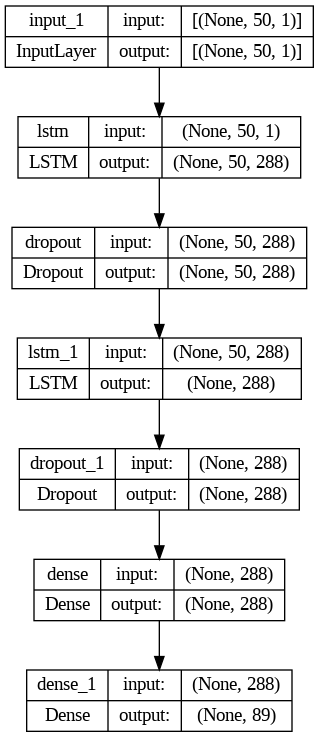

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

## **4.1 Entrenamiento del modelo**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="LSTM.h5",
                                                      monitor="val_loss",
                                                      verbose=True,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      mode="min")
history = model.fit(
 x_train,y_train,
 batch_size=128,epochs=100,
 validation_data=(x_test,y_test))

Epoch 1/100
69/69 [==============================] - 12s 35ms/step - loss: 4.3594 - accuracy: 0.0292 - val_loss: 4.2718 - val_accuracy: 0.0430
Epoch 2/100
69/69 [==============================] - 1s 21ms/step - loss: 4.2768 - accuracy: 0.0356 - val_loss: 4.2178 - val_accuracy: 0.0458
Epoch 3/100
69/69 [==============================] - 1s 21ms/step - loss: 4.2098 - accuracy: 0.0465 - val_loss: 4.1858 - val_accuracy: 0.0444
Epoch 4/100
69/69 [==============================] - 1s 22ms/step - loss: 4.1147 - accuracy: 0.0580 - val_loss: 4.0863 - val_accuracy: 0.0691
Epoch 5/100
69/69 [==============================] - 1s 21ms/step - loss: 4.0050 - accuracy: 0.0749 - val_loss: 3.9469 - val_accuracy: 0.0911
Epoch 6/100
69/69 [==============================] - 1s 21ms/step - loss: 3.8353 - accuracy: 0.1070 - val_loss: 3.8420 - val_accuracy: 0.1034
Epoch 7/100
69/69 [==============================] - 1s 21ms/step - loss: 3.6323 - accuracy: 0.1400 - val_loss: 3.6390 - val_accuracy: 0.1428
Epoch

Veamos el comportamiento del entrenamiento:

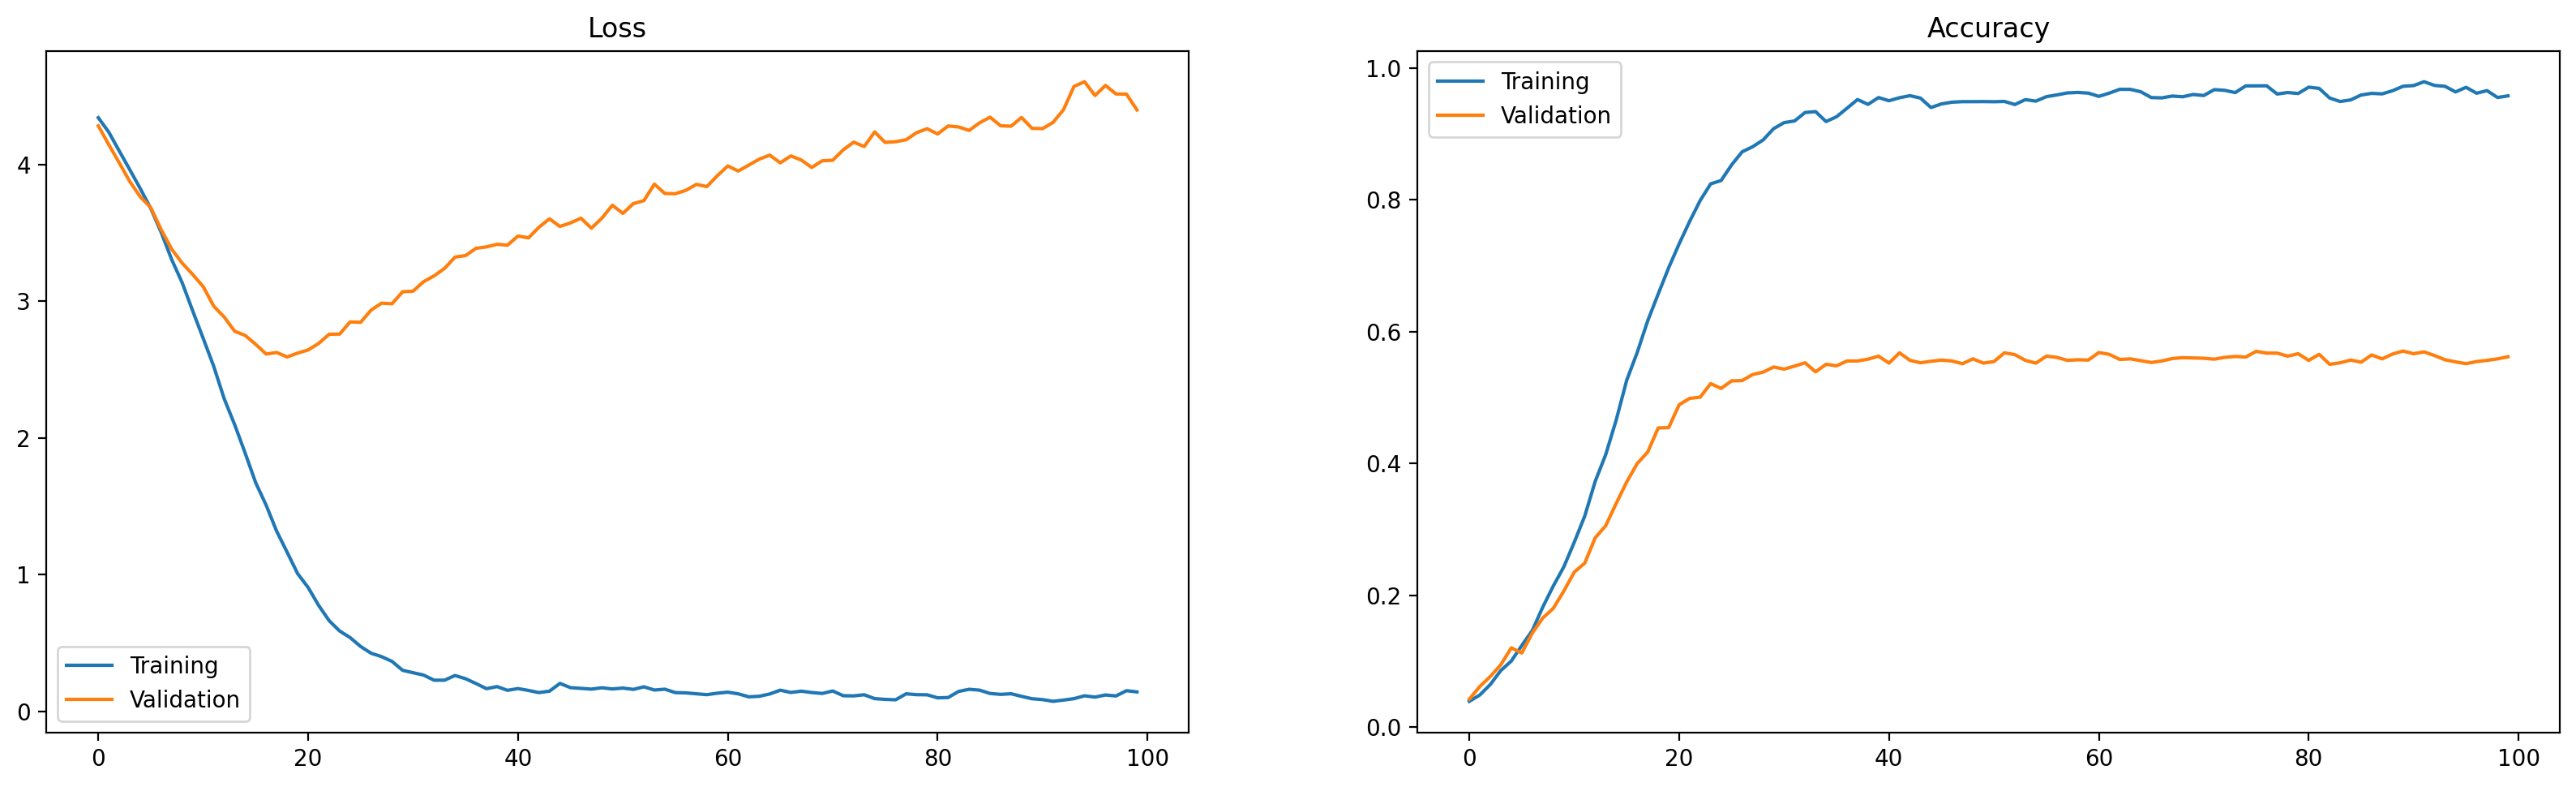

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.show()

Guardamos el modelo:

In [ ]:
model.save("LSTM.h5")

## **4.2 Búsqueda de hiperparámetros**

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner

Vamos a realizar una búsqueda para las unidades de las capas LSTM y la tasa de aprendizaje

In [ ]:
def call_existing_code(units, lr):
  input = tf.keras.layers.Input((x_new.shape[1],x_new.shape[2]))

  capa_LSTM = tf.keras.layers.LSTM(units=units,return_sequences=True)(input)

  dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)

  capa_LSTM = tf.keras.layers.LSTM(units=units)(dropout)

  dropout = tf.keras.layers.Dropout(0.1)(capa_LSTM)

  dense = tf.keras.layers.Dense(units=units,activation='relu')(dropout)

  output = tf.keras.layers.Dense(len(note2ind),activation='softmax')(dense)
  model = tf.keras.models.Model(input, output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

def build_model(hp):
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    # Llamamos el modelo existente con los valores de los hiperparámetros
    model = call_existing_code(lr=lr, units=units)
    return model

Comenzamos la búsqueda

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="",
    project_name="music",
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [ ]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

Trial 3 Complete [00h 01m 25s]
val_accuracy: 0.05263157933950424

Best val_accuracy So Far: 0.17551486939191818
Total elapsed time: 00h 04m 13s


Resultados de la búsqueda:

In [ ]:
tuner.results_summary()

Results summary
Results in ./music
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
lr: 0.002464337661335635
units: 256
Score: 0.17551486939191818

Trial 1 summary
Hyperparameters:
lr: 0.00032699677404287816
units: 96
Score: 0.11853546649217606

Trial 2 summary
Hyperparameters:
lr: 0.0032782554287141517
units: 352
Score: 0.05263157933950424


# **5. Predicción de las notas**

In [ ]:
def note_prediction(n): #n se refiere al número de notas generadas
  #cargamos el modelo
  model = tf.keras.models.load_model("LSTM.h5")
  #generamos un índice aleatoriamente
  index = np.random.randint(0,len(x_test)-1)
  #Datos generados a partir del index de x_test
  music_pattern = x_test[index]
  out_pred=[]

  for i in range(n):
    #redimensionamos la variable music_pattern
    music_pattern = music_pattern.reshape(1,len(music_pattern),1)
    #Buscamos los valores con mayor probabilidad
    pred_index = np.argmax(model.predict(music_pattern))
    out_pred.append(ind2note[pred_index])
    music_pattern = np.append(music_pattern,pred_index)
    #Actualizamos music_pattern con un intervalo entre notas más adelante
    music_pattern = music_pattern[1:]
  return out_pred

# **6. Generación del archivo MIDI**

In [ ]:
def midi_gen(n):
  output_notes = []
  for offset,pattern in enumerate(note_prediction(n)):
    #si el patrón es un acorde
    if ('.' in pattern) or pattern.isdigit():
      #dividimos las notas del acorde
      notes_in_chord = pattern.split('.')
      notes = []
      for current_note in notes_in_chord:
          i_curr_note=int(current_note)
          new_note = note.Note(i_curr_note)
          new_note.storedInstrument = instrument.Piano()
          notes.append(new_note)

      new_chord = chord.Chord(notes)
      new_chord.offset = offset
      output_notes.append(new_chord)

    else:
      #aplicamos el offset
      new_note = note.Note(pattern)
      new_note.offset = offset
      new_note.storedInstrument = instrument.Piano()
      output_notes.append(new_note)

  #guardamos el archivo MIDI
  midi_stream = stream.Stream(output_notes)
  preds = midi_stream.write('midi', fp='pred_music.mid')
  return preds

In [ ]:
midi_gen(100)

1/1 [==============================] - 0s 38ms/step


'pred_music.mid'

# **7. Despliegue del modelo con fastAPI**

Para la generación del midi se requiere del usuario el número de notas que debe tener la melodía. Además se debe contar con los datos de entrenamiento (particularmente X_test) y las funciones note_prediction(n) y midi_gen(n)

In [ ]:
pip install fastapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.4 MB/s eta 0:00:00


In [1]:
%%writefile main.py
import tensorflow as tf
import numpy as np
from music21 import *

from fastapi import FastAPI
from fastapi.response import FileResponse
from pydantic import BaseModel

file_path = '/GioSanToR/MLDS6/tree/main/src/nombre_paquete/deployment'

model = tf.keras.models.load_model('LSTM.h5')

app = FastAPI()

class UserInput(BaseModel):
    user_input: int

@app.get('/')
async def index():
    return {"Message": "Alive"}

@app.post('/midi/')
async def predict(UserInput: UserInput):
    if user_input > 0:
      prediction = midi_gen([UserInput.user_input])
    else:
      return ("número inválido de notas")

    return FileResponse(path = file_path, filename = prediction)

Writing main.py
